In [1]:
import torch
from torch.autograd import grad
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

2023-08-27 19:10:54.168661: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 19:10:54.244569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 19:10:55.470922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def compute_penalty(losses,dummy_w):
    g1=grad(losses[0::2].mean(),dummy_w,create_graph=True)[0] # minibatch 1
    g2=grad(losses[1::2].mean(),dummy_w,create_graph=True)[0] # minibatch 2
    return(g1*g2).sum() 

In [9]:
def example_1(n=10000,d=1,env=1): 
    x=torch.randn(n,d)*env 
    y=x+torch.randn(n,d)*env 
    z=y+torch.randn(n,d) 
    return torch.cat((x,z),1), y.sum(1,keepdim=True) 

In [10]:
env_1 = example_1(env=1.0)
env_2 = example_1(env=0.1)

environments = [env_1, env_2]

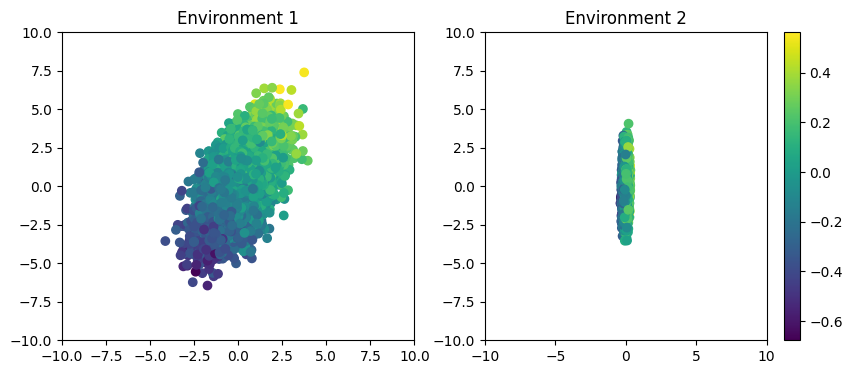

In [11]:
# let's look at the data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(env_1[0][:,0], env_1[0][:,1], c=env_1[1].squeeze())
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title("Environment 1")
plt.subplot(1, 2, 2)
plt.scatter(env_2[0][:,0], env_2[0][:,1], c=env_2[1].squeeze())
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title("Environment 2")
plt.colorbar()

In [20]:
phi = torch.nn.Parameter(torch.ones(2, 1))
dummy_w = torch.nn.Parameter(torch.Tensor([1.0]))
opt = torch.optim.SGD([phi], lr=1e-3)
mse = torch.nn.MSELoss(reduction="none")

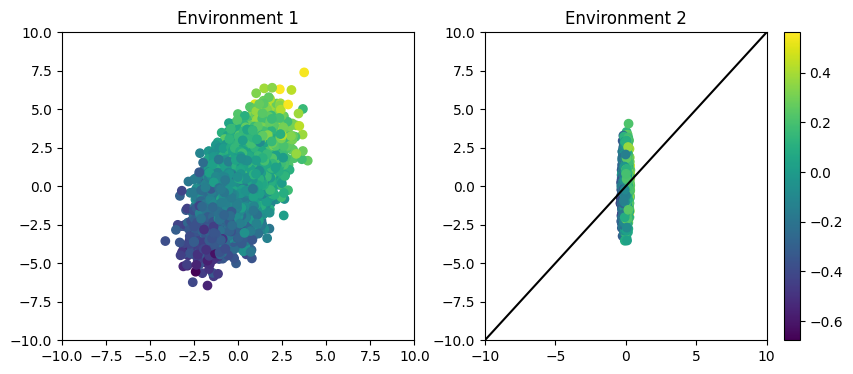

In [21]:
# let's look at the initial model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(env_1[0][:,0], env_1[0][:,1], c=env_1[1].squeeze())
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title("Environment 1")
plt.subplot(1, 2, 2)
plt.scatter(env_2[0][:,0], env_2[0][:,1], c=env_2[1].squeeze())
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title("Environment 2")
plt.colorbar()
# plot the decision boundary
plt.plot([-10, 10], [-10*phi[0].item(), 10*phi[0].item()], c="black")



/tmp/ipykernel_312551/1275086237.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


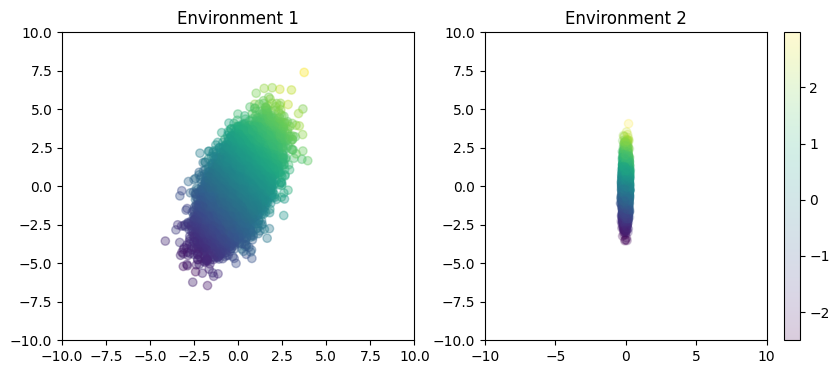

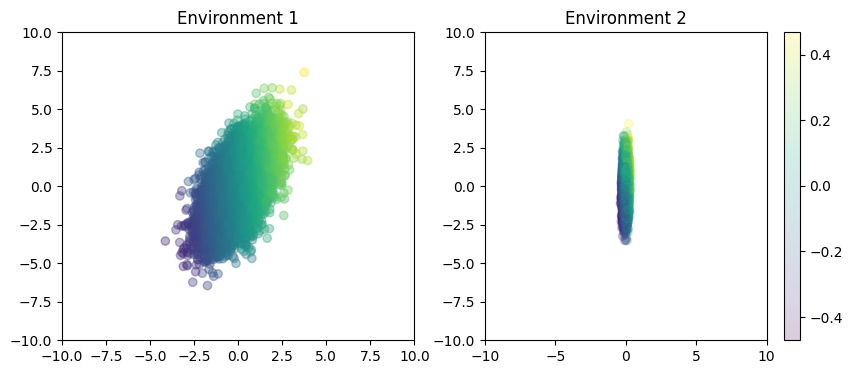

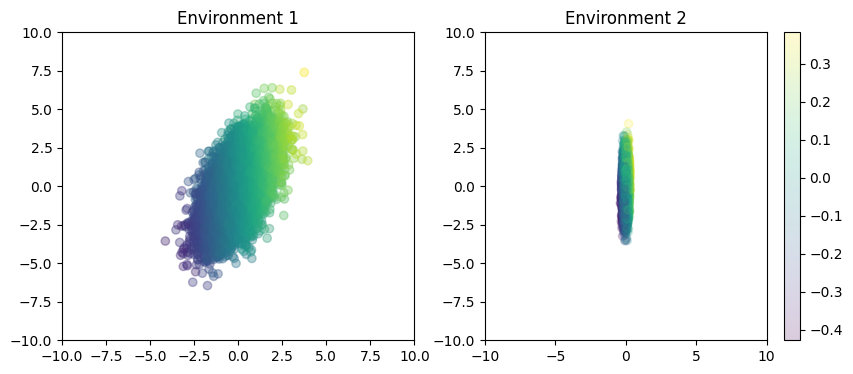

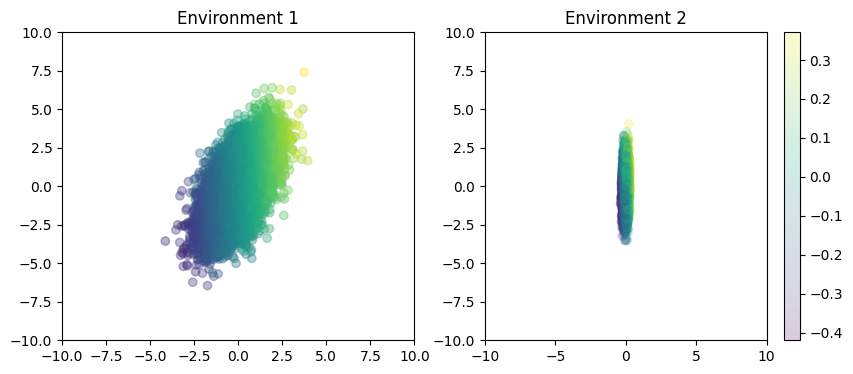

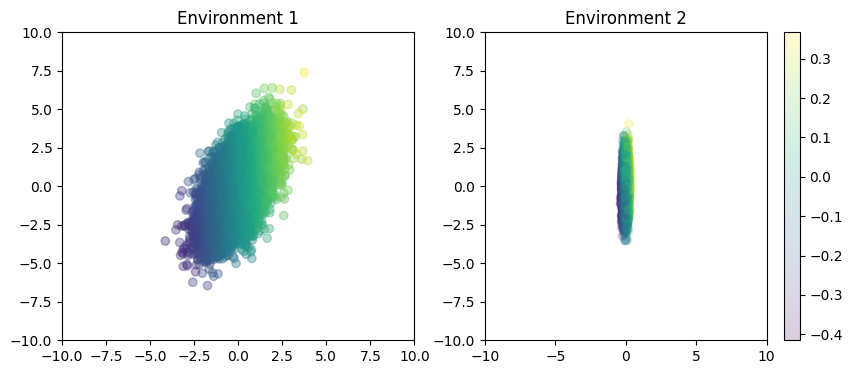

In [22]:
for iteration in range(50000): 
    error=0 
    penalty=0 
    for x_e,y_e in environments: 
        p=torch.randperm(len(x_e)) 
        error_e=mse(x_e[p]@phi*dummy_w, y_e[p]) 
        penalty+=compute_penalty(error_e,dummy_w) # IRM term
        error+=error_e.mean() # ERM term
        opt.zero_grad() 
        (1e-4*error+penalty).backward(retain_graph=True) 
        opt.step() 
    if iteration%10000==0: 
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.scatter(env_1[0][:,0], env_1[0][:,1], c=env_1[1].squeeze(), alpha=0.2)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.title("Environment 1")
        plt.subplot(1, 2, 2)
        plt.scatter(env_2[0][:,0], env_2[0][:,1], c=env_2[1].squeeze(), alpha=0.2)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.title("Environment 2")
        plt.colorbar()
        # plot the transformed data 
        plt.subplot(1, 2, 1)
        plt.scatter(env_1[0][:,0], env_1[0][:,1], c=(env_1[0]@phi.detach().numpy()).squeeze(), alpha=0.2)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.title("Environment 1")
        plt.subplot(1, 2, 2)
        plt.scatter(env_2[0][:,0], env_2[0][:,1], c=(env_2[0]@phi.detach().numpy()).squeeze(), alpha=0.2)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.title("Environment 2")
        plt.colorbar()
        plt.show()